In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import gcf
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn2
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.express as px
import numpy as np 

%matplotlib inline
init_notebook_mode()



In [ ]:
import alphastats


<!-- # Corrected data development -->

In [221]:
test = pd.read_csv("../output/aps_data_csf_corrected_csf_development.tsv",sep = '\t')
cols = test.columns.tolist()
test.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)
test[cols].to_csv("../output/aps_data_csf_corrected_csf_development_nameswap.tsv", index = False, sep='\t')

test = pd.read_csv("../output/aps_data_csf_corrected_csf_validation.tsv",sep = '\t')
cols = test.columns.tolist()
test.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)
test[cols].to_csv("../output/aps_data_csf_corrected_csf_validation_nameswap.tsv", index = False, sep='\t')

DataSet has been created.
Attributes of the DataSet can be accessed using: 
DataSet.rawinput:	 Raw Protein data.
DataSet.mat:		Processed data matrix with ProteinIDs/ProteinGroups as columns and samples as rows. All computations are performed on this matrix.
DataSet.metadata:	Metadata for the samples in the matrix. Metadata will be matched with DataSet.mat when needed (for instance Volcano Plot).
Data has been log2-transformed.
Calculating Students t-test...


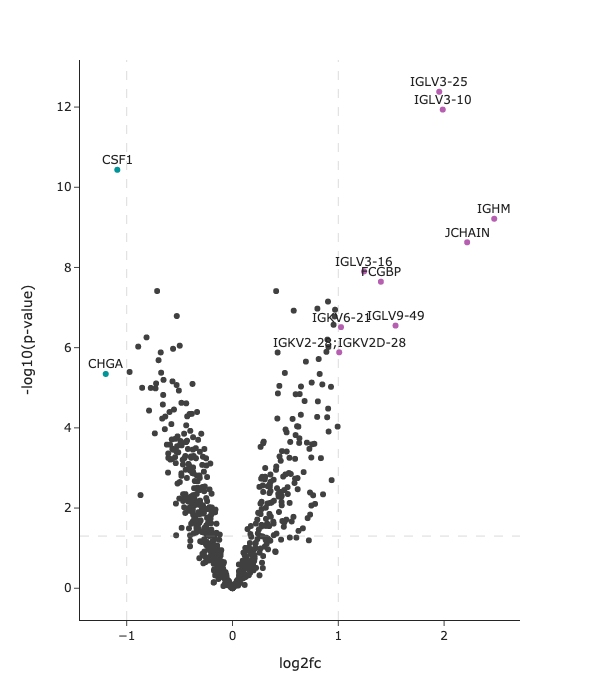

In [222]:
loader = alphastats.DIANNLoader(file = "../output/aps_data_csf_corrected_csf_development_nameswap.tsv")
dataset = alphastats.DataSet(
    loader = loader, 
    metadata_path="../output/aps_meta_csf.xlsx", 
    sample_column="sample_id"
)
dataset.preprocess(
    log2_transform=True,
    remove_contaminations=True
)
volcano_plot = dataset.plot_volcano(
    column="group", # column in metadata
    group1="LNB",
    group2="nonLNB",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)
volcano_plot.show(renderer = "png")

Calculating Students t-test...


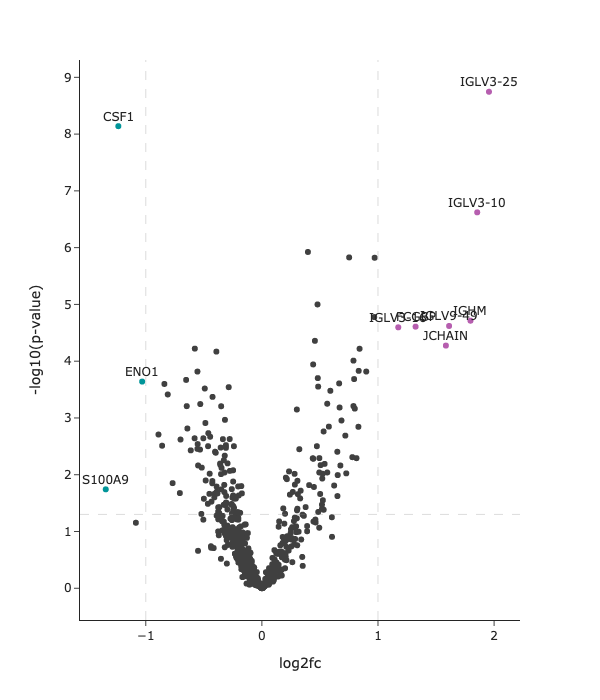

In [223]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="VM",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

#pio.write_image(volcano_plot, '../output/volcano_plot_dev_LNB_VM.svg', format='svg')

volcano_plot.show(renderer = "png")


Calculating Students t-test...


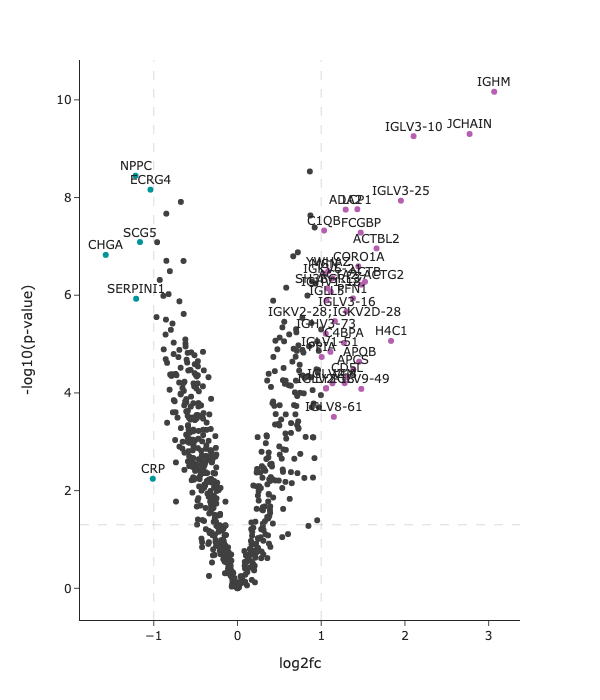

In [224]:
volcano_plot = dataset.plot_volcano(
    column="diagnosis", # column in metadata
    group1="LNB",
    group2="control",
    labels=True, # add label to significantly enriched proteins
    alpha=0.05 # cutoff for pvalue
)

#pio.write_image(volcano_plot, '../output/volcano_plot_dev_LNB_control.svg', format='svg')

volcano_plot.show(renderer = "png")


In [225]:
diff_exp = dataset.diff_expression_analysis('LNB','nonLNB',column='group', fdr=0.05)
print('UP: {}, DOWN: {}'.format(diff_exp[(diff_exp.pval<0.05)&(diff_exp.log2fc>1)]['Protein.Group'].tolist(), diff_exp[(diff_exp.pval<0.05)&(diff_exp.log2fc<-1)]['Protein.Group'].tolist()))
dev_corr = diff_exp[(diff_exp.pval<0.05)&(diff_exp.log2fc.abs()>1)]['Protein.Group'].tolist()

UP: ['IGLV3-16', 'IGLV3-10', 'IGKV2-28;IGKV2D-28', 'IGLV9-49', 'IGKV6-21', 'JCHAIN', 'IGLV3-25', 'IGHM', 'FCGBP'], DOWN: ['CSF1', 'CHGA']


<!-- # get go categories -->

In [226]:
csf_proteins = test[['Genes']].drop_duplicates()
print(csf_proteins.shape)
csf_proteins['Protein.Group'] = csf_proteins['Genes'].str.split(';')
csf_proteins = csf_proteins.explode('Protein.Group').drop_duplicates()
print(csf_proteins.shape)
#csf_proteins.to_csv('../output/csf_proteins.tsv', sep='\t', index=False)
print(diff_exp[diff_exp.pval<0.05].shape)

(654, 1)
(676, 2)
(391, 3)


<!-- There is a easy way to get your GO terms from Uniprot Id. Follow this steps

Go to the UniProt retrieve/IS mapping page located at https://www.uniprot.org/uploadlists/

Introduce your list of UniProt Ids

Set the UniprotKB AC/ID to Uniprot KB option (the default option)

Hit submit

In the table that appears, select the Columns Tab to choose the fields you want to see. There is a GO Ontology section where you can choose 5 different options to see

Hit Save

Download the data. There are many different formats to choose -->

In [227]:
uniprot_mapping = pd.read_csv('../data/uniprot_mapping.tsv', sep='\t')
# subset to reviewed variants
#uniprot_mapping = uniprot_mapping[uniprot_mapping['Reviewed']=='reviewed'][['Entry','Entry Name', 'Protein names', 'Gene Names','Gene Ontology (biological process)']]
uniprot_mapping = uniprot_mapping[['Entry','Entry Name', 'Protein names', 'Gene Names','Gene Ontology (biological process)']]
uniprot_mapping['GO'] = uniprot_mapping['Gene Ontology (biological process)'].str.split('; ')
uniprot_mapping = uniprot_mapping.drop('Gene Ontology (biological process)', axis=1).explode('GO').drop_duplicates()
uniprot_mapping.GO.value_counts()


GO
cell adhesion [GO:0007155]                                                      87
immune response [GO:0006955]                                                    65
adaptive immune response [GO:0002250]                                           61
proteolysis [GO:0006508]                                                        42
innate immune response [GO:0045087]                                             41
                                                                                ..
regulation of synaptic vesicle clustering [GO:2000807]                           1
post-translational protein targeting to membrane, translocation [GO:0031204]     1
negative regulation of IRE1-mediated unfolded protein response [GO:1903895]      1
maintenance of protein localization in endoplasmic reticulum [GO:0035437]        1
Roundabout signaling pathway [GO:0035385]                                        1
Name: count, Length: 2784, dtype: int64

In [228]:
uniprot_mapping.Entry.unique().shape

(672,)

In [229]:
# add additional columns to the uniprot mapping for protein.Groups with muyltiple identifiers
additional_columns = []
for i in test.Genes.tolist():
    if ';' in i:
        multiple_ids = i.split(';')
        print(multiple_ids)
        combined_df = uniprot_mapping[uniprot_mapping['Entry'].isin(multiple_ids)].astype(str)
        collapsed_df = combined_df.apply(lambda col: '; '.join(col)).to_frame().T
        collapsed_df.Entry = i
        additional_columns.append(collapsed_df)
additional_columns = pd.concat(additional_columns)
additional_columns['GO'] = additional_columns['GO'].str.split('; ')
additional_columns = additional_columns.explode('GO').drop_duplicates()
print(uniprot_mapping.shape)
uniprot_mapping = pd.concat([uniprot_mapping, additional_columns]).reset_index(drop=True)
print(uniprot_mapping.shape)


['A0A075B6P5', 'P01615']
['A0A075B6R9', 'A0A0C4DH68']
['A0A087WW87', 'P01614']
['A0A0C4DH73', 'P01611']
['A0A0R4J2G7', 'A0A1D5RMU6', 'E7ERL8']
['A0A804HKL8', 'E7EN28', 'E7ESV6', 'E7ETE3', 'E7EUP0', 'E7EUW2', 'E7EVD6', 'E7EX52']
['C9JGG1', 'C9JJ79']
['P01597', 'P04432']
['P0CG47', 'P0CG48', 'P62979', 'P62987']
['P0DOY2', 'P0DOY3']
['P62736', 'P63267']
['P63241', 'Q6IS14', 'Q9GZV4']
(6504, 5)
(6579, 5)


In [230]:
# Get go categories
GO_order = uniprot_mapping.groupby('GO').size().sort_values(ascending = False).reset_index()['GO'].tolist()
# assign category to uniprot_mapping
uniprot_mapping['GO'] = pd.Categorical(uniprot_mapping['GO'], categories=GO_order, ordered=True)
# subset to most frequent categories
print(uniprot_mapping['GO'].unique().shape)
annotation_test = uniprot_mapping.sort_values(['Gene Names','GO','Entry']).drop_duplicates(subset = 'Gene Names', keep = 'first')
annotation_test.to_csv('../output/annotation_table.tsv', sep = '\t', index = None)
print(annotation_test.GO.unique().shape)
# only keep frequent mappings
annotation_test.GO = annotation_test.GO.astype(str)
GO_order = uniprot_mapping.groupby('GO').size().sort_values(ascending = False).reset_index()
GO_max = GO_order[GO_order[0]>=10]['GO'].tolist()
annotation_test.loc[~annotation_test.GO.isin(GO_max), 'GO'] = 'other'
annotation_test.fillna('none', inplace=True)
print(annotation_test.GO.unique().shape)
# assign category to uniprot_mapping with new categories
GO_order = annotation_test['GO'].unique().tolist()
annotation_test['GO'] = pd.Categorical(annotation_test['GO'], categories=GO_order, ordered=True)


(2786,)
(171,)
(61,)


<!-- # Diff analysis -->

['LNB', 'VM']
(181, 9)
UP: ['IGLV3-16', 'IGLV3-10', 'IGLV9-49', 'JCHAIN IGCJ IGJ', 'IGLV3-25', 'IGHM', 'FCGBP']
DOWN: ['S100A9 CAGB CFAG MRP14', 'ENO1 ENO1L1 MBPB1 MPB1', 'CSF1']
(10, 9)
10
['LNB', 'control']
(474, 9)
UP: ['IGLV8-61', 'IGLV2-18', 'IGLV3-16', 'IGLV3-10', 'IGKV2-28; IGKV2-28; IGKV2D-28; IGKV2D-28', 'IGHV3-73', 'IGLV9-49', 'IGKV6-21', 'IGHV1-18', 'APOB', 'IGLL5', 'CD5L API6 UNQ203/PRO229', 'JCHAIN IGCJ IGJ', 'IGLV1-51', 'IGLV2-8', 'IGLV3-25', 'IGHM', 'APCS PTX2', 'C1QB', 'C4BPA C4BP', 'PFN1', 'VIM', 'LCP1 PLS2', 'MSN', 'CORO1A CORO1', 'ACTB', 'LYZ LZM', 'ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTA2 ACTSA ACTVS GIG46; ACTG2 ACTA3 ACTL3 ACTSG; ACTG2 ACTA3 ACTL3 ACTSG', 'H4C1 H4/A H4FA HIST1H4A; H4C2 H4/I H4FI HIST1H4B; H4C3 H4/G H4FG HIST1H4C

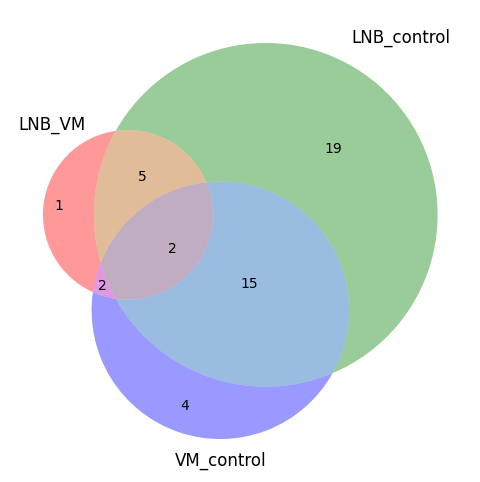

In [233]:
diffs = []
dfs = []
for groups in [['LNB','VM'],['LNB','control'],['control','VM']]:
    print(groups)
    diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
    diff_df = pd.merge(test[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
    diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
    diff_df = diff_df[(diff_df.pval<0.05)]
    diff_df = pd.merge(diff_df, annotation_test[['Entry','GO','Gene Names']], left_on = 'Protein.Group', right_on = 'Entry', how = 'left')
    diff_df['group1']=groups[0]
    diff_df['group2']=groups[1]
    print(diff_df.shape)
    print('UP: {}'.format(diff_df[(diff_df.log2fc>1)]['Gene Names'].tolist()))
    print('DOWN: {}'.format(diff_df[(diff_df.log2fc<-1)]['Gene Names'].tolist()))
    diff_df = diff_df[(diff_df.log2fc.abs()>1)]
    dfs.append(diff_df)
    print(diff_df.shape)
    diff_df = diff_df['Protein.Group'].tolist()
    print(len(diff_df))
    diffs.append(diff_df)

plt.figure(figsize=(6, 6))

# Make the diagram
venn3(subsets = [set(diffs[0]), set(diffs[1]), set(diffs[2])], set_labels=('LNB_VM','LNB_control','VM_control'))

#plt.savefig("venn_diagram_healthy_pls1_pls2.png", format="png")
plt.show()

In [235]:
pd.concat([dfs[0], dfs[1]])[['group1', 'group2','Protein.Group', 'Genes', 'pval', 'log2fc', 'GO']].to_excel('../output/significant_csf_dev.xlsx', index = None)
print(dfs[0]['Protein.Group'].unique().shape)
print(dfs[1]['Protein.Group'].unique().shape)

(10,)
(41,)


In [146]:
# plt.figure(figsize=(6, 6))

# # Make the diagram
# venn3(subsets = [set(diffs[0]), set(diffs[1]), set(dev_corr)], set_labels=('LNB_VM','LNB_control','LNB_nonLNB'))

# #plt.savefig("venn_diagram_healthy_pls1_pls2.png", format="png")
# plt.show()

In [147]:
# plt.figure(figsize=(6, 6))

# # Make the diagram
# venn2([set(diffs[0]), set(diffs[1])], set_labels=('LNB_VM','LNB_control'))

# #plt.savefig("../output/venn_diagram_csf_dev.svg", format="svg")
# plt.show()

<!-- --> Use the combination of two comparisons to make heatmap. -->

In [148]:
# combined_lst = list(set(diffs[0]+diffs[1]))
# #pd.DataFrame(combined_lst, columns = ['csf_identifiers']).to_csv('../output/combined_lst.csv', index = None)


In [149]:
# len(combined_lst)

In [150]:
# diffs = []
# for groups in [['LNB','VM'],['LNB','control'],['control','VM']]:
#     diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
#     diff_df = pd.merge(test[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
#     diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
#     diff_df = diff_df[(diff_df.pval<0.05)]['Protein.Group'].tolist()
#     diffs.append(diff_df)

# combined_lst_pval = list(set(diffs[0]+diffs[1]))
# #pd.DataFrame(combined_lst_pval, columns = ['csf_identifiers_pval']).to_csv('../output/combined_lst_pval.csv', index = None)
# print(len(combined_lst_pval))


<!-- # Heatmap -->

In [151]:
# info = pd.read_table('../output/aps_meta_csf.tsv', sep ='\t')
# info.sample_id = ['csf'+x for x in info.sample_id.astype(str).tolist()]
# aps_data = pd.read_table('../output/aps_data_csf_corrected_csf_development.tsv', sep ='\t').drop(['Protein.Names','Genes','First.Protein.Description'], axis = 1)
# aps_data = aps_data.set_index(['Protein.Group']).T.reset_index()
# aps_data.rename(columns={'index':'sample_id'}, inplace=True)
# heatmap_data = np.log2(pd.merge(info, aps_data, on = 'sample_id').sort_values(['diagnosis','study_cohort']).set_index(['sample_id','diagnosis','study_cohort']).T)



In [152]:
# len(combined_lst)

In [153]:
# heatmap_data = np.log2(pd.merge(info, aps_data, on = 'sample_id')
#                        .sort_values(['diagnosis','study_cohort'])
#                        .set_index(['sample_id','diagnosis','study_cohort'])
#                        .T)
# print(heatmap_data.shape)
# heatmap_data = heatmap_data.loc[heatmap_data.index.get_level_values(0).isin(combined_lst)].T
# print(heatmap_data.shape)
# heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
# heatmap_data = heatmap_data.T

# # merge annotation with heatmap_data:
# annotation_test = pd.merge(pd.DataFrame(heatmap_data.index.tolist(), columns = ['Entry']), annotation_test[['Entry','GO','Gene Names']], on = 'Entry', how = 'left')
# annotation_test['Gene Names']=annotation_test['Gene Names'].str.split(' ').str[0]


# # 2. Add 'annotation' and 'Gene Names' from annotation_test to the index
# annotations = annotation_test['GO'].tolist()  # Replace 'GO' with the correct column name if needed
# gene_names = annotation_test['Gene Names'].tolist()  # Ensure 'Gene Names' is the correct column

# # Creating a MultiIndex
# heatmap_data.index = pd.MultiIndex.from_tuples(
#     list(zip(gene_names, heatmap_data.index)),
#     names=['Gene Names', 'Entry']
# )
# # # annotation colors
# # annotation_labels = heatmap_data.index.get_level_values("annotation")
# # corr_pal = sns.hls_palette(annotation_labels.unique().size)
# # corr_lut = dict(zip(map(str, annotation_labels.unique()), corr_pal))
# # # create correlation index
# # annotation_colors = pd.Series(annotation_labels, index=heatmap_data.index).map(corr_lut)

# # grouping colors
# group_labels = heatmap_data.columns.get_level_values("diagnosis")
# group_pal = sns.color_palette('Set2',group_labels.unique().size)
# group_lut = dict(zip(map(str, group_labels.unique()), group_pal))
# # create group index
# group_colors = pd.Series(group_labels, index=heatmap_data.columns).map(group_lut)

# g1 = sns.clustermap(heatmap_data, z_score=False, col_cluster=False,
#                    #figsize=(30,60), col_colors = group_colors, row_colors = annotation_colors, 
#                    figsize=(35,12), col_colors = group_colors, #row_colors = annotation_colors, 
#                    linewidth=0.5, cmap = "coolwarm", center = 0,
#                    dendrogram_ratio=0.15, metric = 'euclidean', colors_ratio=0.018)

# # add legends
# for label in group_labels.unique():
#     g1.ax_col_dendrogram.bar(0, 0, color=group_lut[label], label=label, linewidth=0);
# l1 = g1.ax_col_dendrogram.legend(title='Group', loc="center", ncol=7, bbox_to_anchor=(0.5, 1), bbox_transform=gcf().transFigure)
# g1.fig.subplots_adjust(right=0.7)
# #g.ax_cbar.set_position((0.8, .2, .03, .4))

# #g1.figure.savefig("../output/heatmap_csf_development_annotation.svg")

In [154]:
# print(' ,'.join(heatmap_data.index.get_level_values("Gene Names").tolist()))

In [155]:
# row_linkage = g1.dendrogram_row.linkage

In [156]:
test =uniprot_mapping.loc[(uniprot_mapping.Entry.isin(heatmap_data.index.get_level_values("Entry").tolist()))]
test.GO = test.GO.astype(str)

sub = test.GO.value_counts().reset_index()

test.loc[~(test.GO.isin(sub[sub['count']>=3]['GO'].tolist())),'GO'] = 'low'

# add missing Entries
test = pd.merge(pd.DataFrame(heatmap_data.index.get_level_values("Entry").tolist(), columns = ['Entry']), test[['Entry','GO','Gene Names']].drop_duplicates(), on = 'Entry', how = 'left')
print(test.shape)
test.fillna('nan', inplace = True)

In [157]:
# heatmap_order = heatmap_data.iloc[g1.dendrogram_row.reordered_ind].index.get_level_values("Entry").tolist()

In [158]:
# # sort the test according to heatmap
# test['Entry'] = pd.Categorical(test['Entry'], categories=heatmap_order, ordered=True)
# test = test.sort_values(['Entry'])
# test.Entry = test.Entry.astype(str)

In [159]:
# test['Gene Names'] = test['Gene Names'].str.split(' ', expand = True)[0] 

In [160]:
# import plotly.graph_objects as go
# import random
# import plotly.io as pio

# # Data for Sankey plot

# # Get unique values of Genes and annotations
# all_Genes = list(test['Gene Names'].unique())
# #all_Genes.reverse()
# all_annotations = list(test['GO'].unique())


# # Create indices for sankey source (Gene Namess) and targets (annotations)
# test['Gene Names_index'] = test['Gene Names'].apply(lambda x: all_Genes.index(x))
# test = test.sort_values(by='Gene Names_index').reset_index(drop=True)  # Ensure test is sorted by the order of 'all_Genes'
# test['annotation_index'] = test['GO'].apply(lambda x: len(all_Genes) + all_annotations.index(x))

# # Generate a color for each annotation
# colors = ['#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(all_annotations))]

# # Map annotation index to colors
# target_colors = {len(all_Genes) + i: colors[i] for i in range(len(all_annotations))}

# # Create a list of colors for the links based on target node
# link_colors = [target_colors[target] for target in test['annotation_index']]

# # Define node positions for source nodes (x = 0.1 for all sources, y spaced evenly)
# source_y_positions = [i / len(all_Genes) for i in range(len(all_Genes))]  # Evenly spaced source y positions
# source_x_positions = [0.1] * len(all_Genes)  # Fixed x position for sources

# # Only set positions for sources, leave target positions to be automatically placed
# node_x_positions = source_x_positions + [None] * len(all_annotations)  # No x positions for targets
# node_y_positions = source_y_positions + [None] * len(all_annotations)  # No y positions for targets

# # Create Sankey diagram
# fig = go.Figure(go.Sankey(
#     node = dict(
#         pad = 15,
#         thickness = 20,
#         line = dict(color = "black", width = 0.5),
#         label = all_Genes + all_annotations,
#         x = node_x_positions,
#         y = node_y_positions
#     ),
#     link = dict(
#         source = test['Gene Names_index'],  # starting points (Gene Namess)
#         target = test['annotation_index'],  # end points (annotations)
#         value = [1] * len(test),  # each link has equal value (1 for each protein-GO link)
#         color = link_colors  # set the color of links
#     )
# ))

# # Update layout and display the figure
# fig.update_layout(title_text="Sankey Diagram of Protein Gene Names and Annotations", 
#                   font_size=10,
#                   height=800,
#                   width=600)

# # Define the path where you want to save the PDF
# output_path = '../output/annotation_heatmap_csf_development_annotation.svg'

# # Save the figure as a PDF
# #pio.write_image(fig, output_path, format='svg')

# fig.show()

In [161]:
# # Print GO terms for missing entries
# sub = uniprot_mapping[uniprot_mapping['Entry'].isin(test.loc[test.GO=='nan']['Entry'].tolist())]
# #test =uniprot_mapping.loc[(uniprot_mapping.Entry.isin(heatmap_data.index.get_level_values("Entry").tolist()))]
# sub.GO = sub.GO.astype(str)
# sub = sub.GO.value_counts().reset_index()
# #sub[sub.GO.str.contains('immunoglobulin mediated immune response')]
# print(', '.join(sub[sub['count']>=2]['GO'].tolist())) #sub[sub['count']>=2].GO.tolist()


<!-- # Validation -->

In [162]:
# loader = alphastats.DIANNLoader(file = "../output/aps_data_csf_corrected_csf_validation_nameswap.tsv")
# dataset = alphastats.DataSet(
#     loader = loader, 
#     metadata_path="../output/aps_meta_csf.xlsx", 
#     sample_column="sample_id"
# )
# dataset.preprocess(
#     log2_transform=True,
#     remove_contaminations=True
# )
# volcano_plot = dataset.plot_volcano(
#     column="group", # column in metadata
#     group1="LNB",
#     group2="nonLNB",
#     labels=True, # add label to significantly enriched proteins
#     alpha=0.05 # cutoff for pvalue
# )
# volcano_plot.show(renderer = "png")

In [163]:
# volcano_plot = dataset.plot_volcano(
#     column="diagnosis", # column in metadata
#     group1="LNB",
#     group2="VM",
#     labels=True, # add label to significantly enriched proteins
#     alpha=0.05 # cutoff for pvalue
# )

# pio.write_image(volcano_plot, '../output/volcano_plot_dev_LNB_VM.svg', format='svg')

# volcano_plot.show(renderer = "png")

In [164]:
# volcano_plot = dataset.plot_volcano(
#     column="diagnosis", # column in metadata
#     group1="LNB",
#     group2="control",
#     labels=True, # add label to significantly enriched proteins
#     alpha=0.05 # cutoff for pvalue
# )

# pio.write_image(volcano_plot, '../output/volcano_plot_val_LNB_control.svg', format='svg')

# volcano_plot.show(renderer = "png")

['LNB', 'VM']
(239, 7)
UP: ['IGLV3-16', 'IGLV3-10', 'IGLV9-49', 'IGLV3-25']
DOWN: [nan, nan, nan, 'CRP', nan, 'S100A9', 'ENO1', 'PFN1', 'VIM', nan, 'ACTB', 'ACTA2', 'H4C1', nan, nan, nan, nan, nan, 'ACTBL2']
23
['LNB', 'control']
(581, 7)
UP: [nan, 'IGLV8-61', nan, 'IGLV2-18', 'IGLV3-16', 'IGLV3-10', nan, 'IGKV2-28;', nan, nan, nan, nan, nan, nan, nan, nan, 'IGHV3-73', nan, 'IGLV9-49', 'IGKV6-21', 'IGHV1-18', nan, nan, nan, nan, nan, 'APOB', nan, 'IGLL5', 'CD5L', nan, nan, nan, nan, 'JCHAIN', nan, nan, nan, nan, nan, 'IGLV1-51', 'IGLV2-8', nan, 'IGLV3-25', nan, nan, nan, nan, 'IGHM', nan, nan, nan, nan, nan, 'APCS', 'C1QB', nan, nan, nan, nan, nan, nan, 'S100A9', 'PFN1', nan, 'VIM', nan, nan, 'LCP1', nan, nan, nan, nan, nan, 'MSN', 'CORO1A', 'ACTB', 'LYZ', 'ACTA2', 'H4C1', 'PPIA', 'YWHAZ', nan, nan, nan, 'ACTBL2', nan, 'SH3BGRL3', 'ADA2', 'FCGBP']
DOWN: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 'SCG5', nan, 'CSF1', nan, 'CHGA', nan, nan, nan, nan, 'NPPC', nan, nan, n

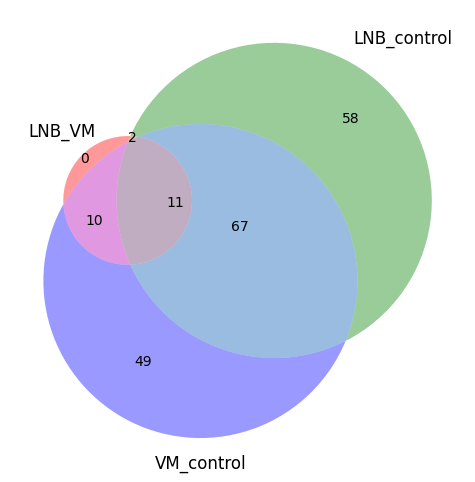

In [165]:
test = pd.read_csv("../output/aps_data_csf_corrected_csf_validation.tsv",sep = '\t')
cols = test.columns.tolist()
test.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)

diffs = []
for groups in [['LNB','VM'],['LNB','control'],['control','VM']]:
    print(groups)
    diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
    diff_df = pd.merge(test[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
    diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
    diff_df = diff_df[(diff_df.pval<0.05)]
    diff_df = pd.merge(diff_df, annotation_test[['Entry','GO','Gene Names']], left_on = 'Protein.Group', right_on = 'Entry', how = 'left')

    print(diff_df.shape)
    print('UP: {}'.format(diff_df[(diff_df.log2fc>1)]['Gene Names'].tolist()))
    print('DOWN: {}'.format(diff_df[(diff_df.log2fc<-1)]['Gene Names'].tolist()))
    diff_df = diff_df[(diff_df.log2fc.abs()>1)]['Protein.Group'].tolist()
    print(len(diff_df))
    diffs.append(diff_df)

plt.figure(figsize=(6, 6))

# Make the diagram
venn3(subsets = [set(diffs[0]), set(diffs[1]), set(diffs[2])], set_labels=('LNB_VM','LNB_control','VM_control'))

#plt.savefig("venn_diagram_healthy_pls1_pls2.png", format="png")
plt.show()

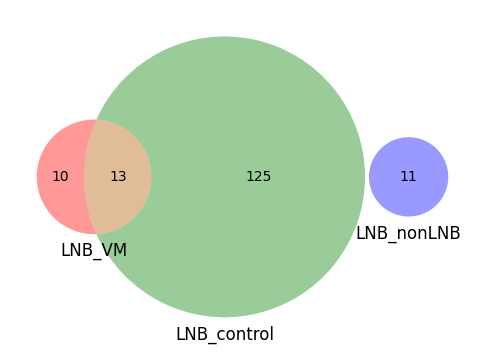

In [166]:
plt.figure(figsize=(6, 6))

# Make the diagram
venn3(subsets = [set(diffs[0]), set(diffs[1]), set(dev_corr)], set_labels=('LNB_VM','LNB_control','LNB_nonLNB'))

#plt.savefig("venn_diagram_healthy_pls1_pls2.png", format="png")
plt.show()


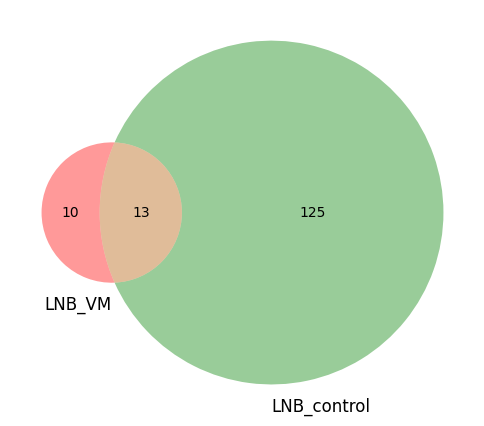

In [167]:
plt.figure(figsize=(6, 6))

# Make the diagram
venn2([set(diffs[0]), set(diffs[1])], set_labels=('LNB_VM','LNB_control'))

#plt.savefig("../output/venn_diagram_csf_dev.svg", format="svg")
plt.show()

<!-- --> Use the combination of two comparisons to make heatmap. -->

In [168]:
combined_lst = list(set(diffs[0]+diffs[1]))
pd.DataFrame(combined_lst, columns = ['csf_identifiers']).to_csv('../output/combined_lst.csv', index = None)


In [169]:
diffs = []
for groups in [['LNB','VM'],['LNB','control'],['control','VM']]:
    diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
    diff_df = pd.merge(test[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
    diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
    diff_df = diff_df[(diff_df.pval<0.05)]['Protein.Group'].tolist()
    diffs.append(diff_df)

combined_lst_pval = list(set(diffs[0]+diffs[1]))
#pd.DataFrame(combined_lst_pval, columns = ['csf_identifiers_pval']).to_csv('../output/combined_lst_pval.csv', index = None)
print(len(combined_lst_pval))


609


In [170]:
# test = pd.read_csv("../output/aps_data_csf_corrected_csf_validation.tsv",sep = '\t')
# cols = test.columns.tolist()
# test.rename(columns={'Protein.Group':'Genes','Genes':'Protein.Group'}, inplace=True)

# diffs = []
# for groups in [['LNB','VM'],['LNB','control'],['control','VM']]:
#     diff_df= dataset.diff_expression_analysis(groups[0],groups[1],column='diagnosis', fdr=0.05)
#     diff_df = pd.merge(test[['Genes','Protein.Group']].drop_duplicates(),diff_df, on = 'Protein.Group')
#     diff_df.rename(columns={'Protein.Group':'Genes', 'Genes':'Protein.Group'}, inplace=True)
#     diff_df = diff_df[(diff_df.pval<0.05)&(diff_df.log2fc.abs()>1)]['Protein.Group'].tolist()
#     diffs.append(diff_df)

# plt.figure(figsize=(6, 6))

# # Make the diagram
# venn3(subsets = [set(diffs[0]), set(diffs[1]), set(diffs[2])], set_labels=('LNB_VM','LNB_control','VM_control'))

# plt.show()

# combined_lst_val = list(set(diffs[0]+diffs[1]))


In [171]:
# combined_lst_val

In [172]:
# plt.figure(figsize=(6, 6))

# # Make the diagram
# venn2([set(combined_lst), set(combined_lst_val)], set_labels=('dev','val'))

# #plt.savefig("../output/venn_diagram_csf_val_dev.svg", format="svg")
# plt.show()


In [173]:
# [x for x in combined_lst if x not in combined_lst_val]

In [174]:
# aps_data = pd.read_table('../output/aps_data_csf_corrected_csf_validation.tsv', sep ='\t').drop(['Protein.Names','Genes','First.Protein.Description'], axis = 1)
# aps_data = aps_data.set_index(['Protein.Group']).T.reset_index()
# aps_data.rename(columns={'index':'sample_id'}, inplace=True)

# heatmap_data = np.log2(pd.merge(info, aps_data, on = 'sample_id')
#                        .sort_values(['diagnosis','study_cohort'])
#                        .set_index(['sample_id','diagnosis','study_cohort'])
#                        .T)
# print(heatmap_data.shape)
# heatmap_data = heatmap_data.loc[heatmap_data.index.get_level_values(0).isin(combined_lst)].T
# print(heatmap_data.shape)
# heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()
# heatmap_data = heatmap_data.T

# # get mean
# mean_df = heatmap_data.T
# heatmap_data = mean_df.groupby(mean_df.index.get_level_values('diagnosis')).mean().T


# # merge annotation with heatmap_data:
# annotation_test = pd.merge(pd.DataFrame(heatmap_data.index.tolist(), columns = ['Entry']), annotation_test[['Entry','GO','Gene Names']], on = 'Entry', how = 'left')


# # 2. Add 'annotation' and 'Gene Names' from annotation_test to the index
# annotations = annotation_test['GO'].tolist()  # Replace 'GO' with the correct column name if needed
# gene_names = annotation_test['Gene Names'].tolist()  # Ensure 'Gene Names' is the correct column

# # Creating a MultiIndex
# heatmap_data.index = pd.MultiIndex.from_tuples(
#     list(zip(gene_names, heatmap_data.index)),
#     names=['Gene Names', 'Entry']
# )
# # # annotation colors
# # annotation_labels = heatmap_data.index.get_level_values("annotation")
# # corr_pal = sns.hls_palette(annotation_labels.unique().size)
# # corr_lut = dict(zip(map(str, annotation_labels.unique()), corr_pal))
# # # create correlation index
# # annotation_colors = pd.Series(annotation_labels, index=heatmap_data.index).map(corr_lut)

# # grouping colors
# group_labels = heatmap_data.columns.get_level_values("diagnosis")
# group_pal = sns.color_palette('Set2',group_labels.unique().size)
# group_lut = dict(zip(map(str, group_labels.unique()), group_pal))
# # create group index
# group_colors = pd.Series(group_labels, index=heatmap_data.columns).map(group_lut)

# g = sns.clustermap(heatmap_data, z_score=False, col_cluster=True,
#                    row_linkage=row_linkage,  # Use row_linkage to cluster rows
#                    figsize=(35,12), col_colors=group_colors, 
#                    linewidth=0.5, cmap="inferno", center=0,
#                    dendrogram_ratio=0.15, metric='euclidean', colors_ratio=0.018)

# # add legends
# for label in group_labels.unique():
#     g.ax_col_dendrogram.bar(0, 0, color=group_lut[label], label=label, linewidth=0);
# l1 = g.ax_col_dendrogram.legend(title='Group', loc="center", ncol=7, bbox_to_anchor=(0.5, 1), bbox_transform=gcf().transFigure)
# g.fig.subplots_adjust(right=0.7)
# #g.ax_cbar.set_position((0.8, .2, .03, .4))

# #g.figure.savefig("../output/heatmap_csf_validation_annotation.svg")


<!-- # ML analysis -->

In [175]:
# ml_data = pd.read_csv("../output/aps_data_csf_corrected_csf_combined.tsv", sep = '\t')
# ml_data = ml_data.set_index(['Protein.Group']).T.reset_index()
# ml_data.rename(columns={'index':'sample_id'}, inplace=True)

# ml_data = np.log2(pd.merge(info,#.replace({'study_cohort':{'csf_development':'csf_validation', 'csf_validation':'csf_development'}}), 
#                            ml_data, on = 'sample_id')
#                        .sort_values(['diagnosis','study_cohort'])
#                        .set_index(['sample_id','diagnosis','study_cohort']).astype(float))
# ml_data.head()

In [176]:
# ml_data = ml_data[combined_lst]
# ml_data.index.set_names(['_sample','_diagnosis','_study'], inplace = True)
# print(ml_data.index.get_level_values('_study').value_counts())
# # change column names to gene names
# gene_mapping_df = uniprot_mapping[uniprot_mapping.Entry.isin(combined_lst)][['Entry','Gene Names']].drop_duplicates()
# gene_mapping_df['Gene Names']=gene_mapping_df['Gene Names'].str.split(' ').str[0].str.split(';').str[0]
# gene_mapping_df.set_index('Entry', inplace = True)

# ml_data.columns = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
# ml_data.to_csv('../output/csf_ml_data.tsv', sep = '\t')

In [177]:
# from sklearn.model_selection import train_test_split, StratifiedKFold#, RandomizedSearchCV, StratifiedKFold, cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve
# from scipy import interp
# import plotly.graph_objects as go
# #from yellowbrick.model_selection import RFECV

# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, roc_curve

# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
# from sklearn.feature_selection import RFECV
# from scipy.stats import zscore


# import numpy as np
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn import ensemble
# from sklearn.linear_model import Perceptron

# from scipy.stats import uniform, truncnorm, randint

# import time

# n_features = len(combined_lst)
# n_samples = int(ml_data.loc[ml_data.index.get_level_values('_study') == 'csf_development'].shape[0]*0.8)


# # hyperparameter grids
# lr_grid = {"C": [0.1, 0.5, 1],#np.logspace(0, 4, num=10),
#            "penalty": ['l1', 'l2','elasticnet'],
#            "solver": ['liblinear', 'saga'],
#            "max_iter":[5000]}
# lda_grid = {"solver": ['svd', 'lsqr', 'eigen'],
#             "shrinkage":[None, 'auto']}
# knn_grid = {"n_neighbors": randint(1,11),
#             "weights":['uniform','distance'], 
#             "algorithm":['auto','ball_tree','kd_tree','brute'], 
#             "leaf_size":randint(10,50), 
#             "p":[1,2],
#             "metric":['euclidean','minkowski','mahalanobis','seuclidean']}
# dt_grid = {"criterion": ["gini", "entropy"],
#             "splitter": ['best','random'],
#             #"max_features": randint(1, n_features),
#             "min_samples_leaf": randint(1, 11),
#             "class_weight":[None, 'balanced']}
# nb_grid = {}
# svc_grid = {"kernel": ['linear'], #'poly', 'rbf', 'sigmoid'], #removed because it does not work with importance getter
#             "gamma":['scale','auto'],
#             "class_weight" : ['balanced',None],
#             "probability" : [True]}
# rf_grid = {"max_depth": [3, None],
#             "min_samples_split": randint(1, 11),
#             "min_samples_leaf": randint(1, 11),
#             "bootstrap": [True, False],
#             "criterion": ["gini", "entropy"],
#             "n_estimators": randint(1,200),
#             "max_features": truncnorm(a=0, b=1, loc=0.25, scale=0.1)}
# nnet_grid = {"hidden_layer_sizes":randint(1,n_features),
#             "activation": ['identity','logistic','tanh','relu'],
#             "solver":['lbfgs','sgd','adam'],
#             "batch_size":[int(n_samples/10),int(n_samples/5), int(n_samples/2)],
#             "learning_rate_init":np.logspace(np.log10(0.00001), np.log10(0.99999), num=10),
#             "max_iter":[5000],
#             "early_stopping":[True],
#             "validation_fraction":[0.25]}
# perceptron_grid = {"penalty": ['l1', 'l2','elasticnet'],
#                    "max_iter":[5000],
#                    "class_weight" : ['balanced',None]}
                   
# gp_grid = {}
# ab_grid = {}
# qda_grid = {}
# eet_grid = {}

# # models
# models = []
# models.append(('LR', lr_grid, LogisticRegression(random_state=7)))
# models.append(('LDA', lda_grid, LinearDiscriminantAnalysis()))
# models.append(('KNN', knn_grid, KNeighborsClassifier()))
# models.append(('DT', dt_grid, DecisionTreeClassifier(random_state=7)))
# models.append(('Naive Bayes', nb_grid, GaussianNB()))
# models.append(('SVC', svc_grid, SVC(random_state=7)))
# models.append(('RF', rf_grid, RandomForestClassifier(random_state=7)))
# models.append(('NNet', nnet_grid, MLPClassifier(random_state=7)))
# #models.append(('Perceptron',perceptron_grid,Perceptron(random_state = 7)))
# models.append(('GP', gp_grid, GaussianProcessClassifier(random_state=7)))
# models.append(('Adaboost', ab_grid, AdaBoostClassifier(random_state=7)))
# models.append(('QDA', qda_grid, QuadraticDiscriminantAnalysis()))
# models.append(('ensembleextratree', eet_grid, ensemble.ExtraTreesClassifier(random_state=7)))
# #import xgboost as xgb
# #models.append(('xgb',xgb_grid,xgb.Data))

In [178]:
# prepared_data = ml_data.copy()
# prepared_data=zscore(prepared_data, axis = 1)
# train_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_development')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','VM']))]

# no_cv = 5
# X = train_data.values # all the protein columns
# sample_lst = train_data.index.get_level_values('_sample').values
# y = pd.Categorical(train_data.index.get_level_values('_diagnosis')).codes # control is 0, LNB is 1 or LNB 0 and VM 1
# #X_train, X_test, y_train, y_test, samples_train, samples_test = train_test_split(X, y, train_data['sample'].tolist(), test_size=0.2, random_state=7, stratify=y)
# X_train = X.copy()
# y_train = y.copy()
# sum(y_train)


In [179]:
# ml_data.reset_index().groupby('_study')._diagnosis.value_counts()

In [180]:
# val_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_validation')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','VM']))]
# X_val = val_data.values
# y_val = pd.Categorical(val_data.index.get_level_values('_diagnosis')).codes
# sum(y_val)

In [181]:
# from itertools import compress
# protein_cols = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
# # ML alg. selection
# optimal_models = []
# optimal_no_features = []
# optimal_features = []
# start_time = time.time()

# dfs = []
# metrics = []
# to_plot = []   
# fitted_models = []
    
# for name, grid, estimator in models:
#     print(name)
#     # grid search
#     selector = RandomizedSearchCV(estimator=estimator, param_distributions=grid, cv=StratifiedKFold(no_cv), scoring = 'f1_weighted', n_jobs = -1)
#     clf = selector.fit(X_train,y_train)
#     optimal_model = clf.best_estimator_
#     optimal_models.append(optimal_model)
#     # feature reduction
#     if name in ['Naive Bayes','NNet', 'GP', 'QDA', 'KNN']: # skip rfecv for models not supported by importance
#         optimal_no_features.append(len(protein_cols))
#         optimal_features.append(protein_cols)
#         print('skipping feature importance')
#         X_reduced = X_train
#         X_val_reduced = X_val
#     else:
#         selector = RFECV(optimal_model, cv=5, scoring='f1_weighted')
#         selector = selector.fit(X_train, y_train)
#         optimal_no_features.append(sum(selector.support_))
#         optimal_features.append(list(compress(protein_cols, selector.support_)))
#         print('optimal no features = {}'.format(sum(selector.support_)))
#         X_reduced = X_train[:,selector.support_]
#         X_val_reduced = X_val[:, selector.support_]
    
#     # compute cv results
#     print('computing predictions for: {}'.format(name))
#     classifier = optimal_model
#     mccs = []
#     aucs = []
#     fits = []
#     mcc_val = []
#     auc_val = []
                            
#     # calculate performance during training
#     cv = StratifiedKFold(n_splits=no_cv)
#     for i, (train, test) in enumerate(cv.split(X_reduced, y_train)):
#         print('cv: {}'.format(i+1))
#         classifier.fit(X_reduced[train], y_train[train])
        
#         fits.append(classifier)
#         # predict for "test" set
#         y_pred = classifier.predict(X_reduced[test])
#         y_prob = classifier.predict_proba(X_reduced[test])[:,1]
#         result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
#         result.columns = ['observed','predicted','probability']
#         result['cv']=i+1
#         result['model']=name
#         result['sample']=sample_lst[test]
#         result['run']='test'
#         dfs.append(result)
#         mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#         aucs.append(round(roc_auc_score(result.observed,result.probability),2))
#         # predict for validation sets
#         y_pred = classifier.predict(X_val_reduced)
#         y_prob = classifier.predict_proba(X_val_reduced)[:,1]
#         result = pd.DataFrame([y_val, y_pred, y_prob]).T
#         result.columns = ['observed','predicted','probability']
#         result['cv']=i+1
#         result['model']=name
#         result['sample']=val_data.index.get_level_values('_sample').tolist()
#         result['run']='val'
#         dfs.append(result)  
#         mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#         auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
        
#     fitted_models.append(fits)
#     #test
#     metrics_results = pd.DataFrame(mccs)
#     metrics_results.columns = ['MCC']
#     metrics_results['AUROC']=aucs
#     metrics_results['cv']=list(range(1,1+no_cv))
#     metrics_results['model']=name
#     metrics_results['run']='test'
#     metrics.append(metrics_results)

#     #val
#     metrics_results = pd.DataFrame(mccs)
#     metrics_results.columns = ['MCC']
#     metrics_results['AUROC']=aucs
#     metrics_results['cv']=list(range(1,1+no_cv))
#     metrics_results['model']=name
#     metrics_results['run']='val'
#     metrics.append(metrics_results)
    
#     mcc_mean = np.mean(mccs)
#     mcc_std = np.std(mccs)
#     auroc_mean = np.mean(aucs)
#     auroc_std = np.std(aucs)
#     to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
#     print('MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
    
#     print('\n{} model tested --- {} minutes ---\n'.format(name,round(((time.time() - start_time)/60),3)))


# result_df = pd.concat(dfs)
# metrics_df = pd.concat(metrics)


In [182]:
# plot_df = pd.DataFrame(to_plot)
# plot_df.columns=['model','mcc_mean','mcc_std','auroc_mean','auroc_std']
# plot_df = round(plot_df,2)
# plot_df['no_features']=[len(x) for x in optimal_features]
# plot_df['features']=optimal_features
# plot_df = plot_df.sort_values('mcc_mean').reset_index(drop = True)
# plot_df['model_n_features']= ['{} (no. proteins = {})'.format(plot_df.loc[i,'model'],plot_df.loc[i,'no_features']) for i in plot_df.index.tolist()]



In [183]:
# def butterfly_plot(df, var1, var2, var3, error1, error2, name, savesvg=True, group = 'model'):
#     fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=False, shared_yaxes=True, horizontal_spacing=0)
#     fig.append_trace(go.Bar(x = df[var1], y = df[group], text = df[var1], error_x=dict(type='data', array=df[error1]), error_y=dict(type='data', array=df[error1]),
#                         textposition='inside', orientation='h', width=0.7, 
#                         showlegend=False, marker_color='#4472c4'), 1, 1) # 1,1 represents row 1 column 1
#     fig.append_trace(go.Bar(x = df[var2], y = df[group], text = df[var2], error_x=dict(type='data', array=df[error2]), error_y=dict(type='data', array=df[error2]),
#                  textposition='inside', orientation='h', width=0.7, 
#                  showlegend=False, marker_color='#ed7d31'), 1, 2) # 1,2 represents row 1 column 2
#     fig.update_xaxes(title_text="Matthews Correlation Coefficient", row=1, col=1, range=[1,0])
#     fig.update_xaxes(title_text="AUROC", row=1, col=2)
#     fig.update_layout(width=800, height=700, title_x=0.5,xaxis1={'side': 'top'},xaxis2={'side': 'top'},)
#     fig.update_layout(template='plotly_white')
#     if savesvg:
#         fig.write_image('/Users/tzx804/projects/collaborations/nicolai/LNB/version3/output/alg_butterfly_{}.svg'.format(name))
#     fig.show()

In [184]:

# from plotly.subplots import make_subplots
# butterfly_plot(plot_df, var1 = 'mcc_mean', var2 = 'auroc_mean', var3 = 'no_features', error1 = 'mcc_std', error2 = 'auroc_std', name = 'csf_VM_27_01_25', savesvg=True, group = 'model_n_features')


In [185]:

# for model in result_df.model.unique():
#     result = result_df[(result_df.model == model)&(result_df.run == 'val')]
#     print(model)
#     print(round(matthews_corrcoef(result.observed, result.predicted),2))
#     #print(round(roc_auc_score(result.observed,result.probability),2))

In [186]:
# selector = RFECV(optimal_models[0], cv=5, scoring='f1_weighted')
# selector = selector.fit(X_train, y_train)

# print(f"Optimal number of features: {selector.n_features_}")


In [187]:
# error_max = selector.cv_results_['mean_test_score']+selector.cv_results_['std_test_score']
# error_min = selector.cv_results_['mean_test_score']-selector.cv_results_['std_test_score']

# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=np.concatenate([list(range(1,len(protein_cols)+1)),list(range(1,len(protein_cols)+1))[::-1]]),
#     y=np.concatenate([error_max, error_min[::-1]]),
#     fill='toself', opacity=0.5, name = '1 std.'))
# fig.add_trace(go.Scatter(x=list(range(1,len(protein_cols)+1)), y = selector.cv_results_['mean_test_score'],
#                          name='Mean test score',line = dict(color='firebrick', width=1)))
# fig.add_trace(go.Scatter(x = [selector.n_features_,selector.n_features_], name = 'Optimal number of features: {}'.format(selector.n_features_), 
#                          y=[0,1], 
#                          mode='lines', 
#                          line=dict(color='green', width=2, dash='dash')))

# fig.update_layout(template='simple_white',
#     autosize=False,
#     width=800,
#     height=500,
#     title="RFECV for SVC classifier",
#     xaxis_title="Number of features selected",
#     yaxis_title="F1-weighted",
#     legend_title="",
#     #legend=dict(y=1.1, orientation='h'),
#     legend_traceorder="reversed",
#     xaxis_range=[0,len(protein_cols)],
#     yaxis_range = [0,max(error_max)])

# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/misc/sepsis/output/RFECV_SVC.pdf')
# fig.show()

In [188]:
# topfeatures_identifiers = list(compress(protein_cols, selector.support_))
# print(topfeatures_identifiers)

In [189]:
# X_train = zscore(X_train[:, selector.support_], axis = 1)
# X_val = zscore(X_val[:, selector.support_], axis =1)


In [190]:
# from sklearn.calibration import CalibratedClassifierCV

# # compute cv results
# print('computing predictions for: {}'.format(optimal_models[0]))
# classifier = optimal_models[0]
# name = 'LR'
# mccs = []
# aucs = []
# fits = []
# mcc_val = []
# auc_val = []
# dfs = []
                        
# # calculate performance during training 
# cv = StratifiedKFold(n_splits=no_cv)
# for i, (train, test) in enumerate(cv.split(X_train, y_train)):
#     print('cv: {}'.format(i+1))
#     classifier.fit(X_train[train], y_train[train])
#     #calibrated = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
#     #calibrated.fit(X_train[train], y_train[train])
#     #classifier = calibrated
#     fits.append(classifier)
#     # predict for "test" set
#     y_pred = classifier.predict(X_train[test])
#     y_prob = classifier.predict_proba(X_train[test])[:,1]
#     result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=sample_lst[test]
#     result['run']='test'
#     dfs.append(result)
#     mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     aucs.append(round(roc_auc_score(result.observed,result.probability),2))
#     # predict for validation sets
#     y_pred = classifier.predict(X_val)
#     y_prob = classifier.predict_proba(X_val)[:,1]
#     result = pd.DataFrame([y_val, y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=val_data.index.get_level_values('_sample').tolist()
#     result['run']='val'
#     dfs.append(result)  
#     mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
    
# mcc_mean = np.mean(mccs)
# mcc_std = np.std(mccs)
# auroc_mean = np.mean(aucs)
# auroc_std = np.std(aucs)
# to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
# print('Test: MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
# print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))

# result = pd.concat(dfs)


In [191]:
# from sklearn.calibration import CalibratedClassifierCV

# # compute cv results
# print('computing predictions for: {}'.format(optimal_models[0]))
# classifier = optimal_models[0]
# name = 'LR'
# mccs = []
# aucs = []
# fits = []
# mcc_val = []
# auc_val = []
# dfs = []
                        
# # calculate performance during training 
# cv = StratifiedKFold(n_splits=no_cv)
# for i, (train, test) in enumerate(cv.split(X_train, y_train)):
#     print('cv: {}'.format(i+1))
#     classifier.fit(X_train[train], y_train[train])
#     #calibrated = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
#     #calibrated.fit(X_train[train], y_train[train])
#     #classifier = calibrated
#     fits.append(classifier)
#     # predict for "test" set
#     y_pred = classifier.predict(X_train[test])
#     y_prob = classifier.predict_proba(X_train[test])[:,1]
#     result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=sample_lst[test]
#     result['run']='test'
#     dfs.append(result)
#     mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     aucs.append(round(roc_auc_score(result.observed,result.probability),2))
#     # predict for validation sets
#     y_pred = classifier.predict(X_val)
#     y_prob = classifier.predict_proba(X_val)[:,1]
#     result = pd.DataFrame([y_val, y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=val_data.index.get_level_values('_sample').tolist()
#     result['run']='val'
#     dfs.append(result)  
#     mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
    
# mcc_mean = np.mean(mccs)
# mcc_std = np.std(mccs)
# auroc_mean = np.mean(aucs)
# auroc_std = np.std(aucs)
# to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
# print('Test: MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
# print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))

# result = pd.concat(dfs)


In [192]:
# print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))


In [193]:
# import scipy.stats as st

# def roc_data(df, model, run):
#     svc_test = df.loc[(df.model == model)&(df.run == run)]
#     fpr_mean = np.linspace(0, 1, 100)
#     interp_tprs = []
#     aucs = []
#     mccs = []
#     for cv in list(range(1,5+1)):
#         svc_sub = svc_test.loc[svc_test.cv == cv]
#         fpr, tpr, thresholds = roc_curve(svc_sub.observed, svc_sub.probability, drop_intermediate=False)
#         interp_tpr = np.interp(fpr_mean, fpr, tpr)
#         interp_tpr[0] = 0.0
#         interp_tprs.append(interp_tpr)
#         aucs.append(roc_auc_score(svc_sub.observed, svc_sub.probability))
#         mccs.append(matthews_corrcoef(svc_sub.observed, svc_sub.predicted))
#         #print(roc_auc_score(svc_sub.observed, svc_sub.probability))
#     tpr_mean     = np.mean(interp_tprs, axis=0)
#     tpr_mean[-1] = 1.0
#     tpr_std      = np.round(np.std(interp_tprs, axis=0),4)
#     tpr_upper    = tpr_mean+tpr_std
#     tpr_lower    = tpr_mean-tpr_std
#     auc_mean = np.round(np.mean(aucs)*100,2)
#     auc_sd = np.round(np.std(aucs)*100,2)
#     ci_lower, ci_upper = np.round([100*x for x in st.t.interval(alpha=0.95, df=len(aucs)-1,loc=np.mean(aucs),scale=st.sem(aucs))],2)
    
#     mcc_mean = np.round(np.mean(mccs),4)
#     mcc_sd = np.round(np.std(mccs),4)
    
#     return(fpr_mean, tpr_mean, tpr_upper, tpr_lower, auc_mean, auc_sd, ci_upper, ci_lower, mcc_mean, mcc_sd)

In [194]:
# fig = go.Figure()
# # ROC for TEST
# test_data = roc_data(result, model = "LR", run = "test")
# # output_order = test_data[0], test_data[1], test_data[2], test_data[3], test_data[4], auc_sd, ci_upper, ci_lower, mcc_mean, mcc_std
# fig.add_trace(go.Scatter(
#     x=np.concatenate([test_data[0],test_data[0][::-1]]),
#     y=np.concatenate([test_data[2], test_data[3][::-1]]),
#     fill='toself', opacity=0.5, name = 'std.'))
# print('TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
# fig.add_trace(go.Scatter(x = test_data[0], name = 'TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
#                          y=test_data[1], 
#                          mode='lines', 
#                          line=dict(color='grey', width=2, dash='dash')))
# test_data = roc_data(result, model = "LR", run = "val")
# print('VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
# fig.add_trace(go.Scatter(x = test_data[0], name = 'VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
#                          y=test_data[1], 
#                          mode='lines', 
#                          line=dict(color='green', width=2)))

# fig.update_layout(template='simple_white',
#     autosize=False,
#     width=1000,
#     height=500,
#     title="AUROC for LR classifier",
#     xaxis_title="TPR",
#     yaxis_title="FPR",
#     legend_title="",
#     legend_traceorder="reversed",
#     xaxis_range=[0,1],
#     yaxis_range = [0,1])
# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/LNB/version3/output/LR_csf_VM_AUC.svg', width = 950)

# fig.show()

In [195]:
# # shaply feature importance
# import shap

# X_train_df = pd.DataFrame(X_train, columns = topfeatures_identifiers)
# X_test_df = pd.DataFrame(X_val, columns = topfeatures_identifiers)

# # Generate the Tree SHAP estimator of Shapley values that corresponds to the LDA we built
# explainer = shap.LinearExplainer(optimal_models[0], X_train_df)
# # Compute the estimated Shapley values for the test sample's observations
# shap_values = explainer.shap_values(X_train_df)

# plt.figure(figsize=(6, 6))
# shap.summary_plot(shap_values, X_train_df,max_display=17,show=False)

# #plt.savefig('../output/shap_plot_csf_VM.svg', format = 'svg') #.png,.pdf will also support here

In [196]:
# result_lr = result.loc[result.model == 'LR']
# # mean
# result_mean = pd.DataFrame(result_lr.groupby('sample').probability.mean())
# result_mean.reset_index(inplace = True)

# result_lr = pd.merge(result_mean,ml_data.reset_index()[['_sample','_study','_diagnosis']], left_on = 'sample', right_on = '_sample').drop('sample', axis = 1)

# result_other = pd.DataFrame(classifier.predict_proba(prepared_data.loc[prepared_data.index.get_level_values('_diagnosis')=='control'][topfeatures_identifiers].values)[:,1], columns = ['probability'])
# result_other[['_sample','_study','_diagnosis']]= prepared_data.loc[prepared_data.index.get_level_values('_diagnosis')=='control'].reset_index()[['_sample','_study','_diagnosis']]

# result_lr = pd.concat([result_other[['_sample','_study','_diagnosis','probability']],result_lr[['_sample','_study','_diagnosis','probability']]])

# result_lr.probability = 100*(1-result_lr.probability)
# result_lr._diagnosis.value_counts()


In [197]:
# fig = px.box(result_lr, x = 'probability', y = '_study', color = '_diagnosis', template = 'simple_white', points = 'all', width = 500, height = 500)
#       #category_orders={"group": ["MIS-C Acute Stage",'MIS-C During Admission','MIS-C Full Recovery', 'Virus','Bacteria','Sepsis','Kawasaki']}, 
#       #color_discrete_sequence=["rgb(57,105,172)", "rgb(47,138,196)","rgb(179,179,179)","rgb(217,175,107)", "rgb(175,100,88)","rgb(204,97,176)","rgb(118,78,159)"])
# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/LNB/version3/output/lr_csf_VM_proba_mean.svg',width = 500, height = 500)
# fig.show()

<!-- # LNB vs control -->

<!--  -->

In [198]:
# prepared_data = ml_data.copy()
# prepared_data=zscore(prepared_data, axis = 1)
# train_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_development')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','control']))]

# no_cv = 5
# X = train_data.values # all the protein columns
# sample_lst = train_data.index.get_level_values('_sample').values
# y = pd.Categorical(train_data.index.get_level_values('_diagnosis')).codes # control is 0, LNB is 1 or LNB 0 and VM 1
# #X_train, X_test, y_train, y_test, samples_train, samples_test = train_test_split(X, y, train_data['sample'].tolist(), test_size=0.2, random_state=7, stratify=y)
# X_train = X.copy()
# y_train = y.copy()
# sum(y_train)


In [199]:
# X_train.shape

In [200]:
# ml_data.reset_index().groupby('_study')._diagnosis.value_counts()

In [201]:
# val_data = prepared_data.loc[(prepared_data.index.get_level_values('_study')=='csf_validation')&(prepared_data.index.get_level_values('_diagnosis').isin(['LNB','control']))]
# X_val = val_data.values
# y_val = pd.Categorical(val_data.index.get_level_values('_diagnosis')).codes
# sum(y_val)

In [202]:
# gene_mapping_df

In [203]:
# from itertools import compress
# protein_cols = gene_mapping_df.loc[combined_lst]['Gene Names'].tolist()
# # ML alg. selection
# optimal_models = []
# optimal_no_features = []
# optimal_features = []
# start_time = time.time()

# dfs = []
# metrics = []
# to_plot = []   
# fitted_models = []
    
# for name, grid, estimator in models:
#     print(name)
#     # grid search
#     selector = RandomizedSearchCV(estimator=estimator, param_distributions=grid, cv=StratifiedKFold(no_cv), scoring = 'f1_weighted', n_jobs = -1)
#     clf = selector.fit(X_train,y_train)
#     optimal_model = clf.best_estimator_
#     optimal_models.append(optimal_model)
#     # feature reduction
#     if name in ['Naive Bayes','NNet', 'GP', 'QDA', 'KNN']: # skip rfecv for models not supported by importance
#         optimal_no_features.append(len(protein_cols))
#         optimal_features.append(protein_cols)
#         print('skipping feature importance')
#         X_reduced = X_train
#         X_val_reduced = X_val
#     else:
#         selector = RFECV(optimal_model, cv=5, scoring='f1_weighted')
#         selector = selector.fit(X_train, y_train)
#         optimal_no_features.append(sum(selector.support_))
#         optimal_features.append(list(compress(protein_cols, selector.support_)))
#         print('optimal no features = {}'.format(sum(selector.support_)))
#         X_reduced = X_train[:,selector.support_]
#         X_val_reduced = X_val[:, selector.support_]
    
#     # compute cv results
#     print('computing predictions for: {}'.format(name))
#     classifier = optimal_model
#     mccs = []
#     aucs = []
#     fits = []
#     mcc_val = []
#     auc_val = []
                            
#     # calculate performance during training
#     cv = StratifiedKFold(n_splits=no_cv)
#     for i, (train, test) in enumerate(cv.split(X_reduced, y_train)):
#         print('cv: {}'.format(i+1))
#         classifier.fit(X_reduced[train], y_train[train])
        
#         fits.append(classifier)
#         # predict for "test" set
#         y_pred = classifier.predict(X_reduced[test])
#         y_prob = classifier.predict_proba(X_reduced[test])[:,1]
#         result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
#         result.columns = ['observed','predicted','probability']
#         result['cv']=i+1
#         result['model']=name
#         result['sample']=sample_lst[test]
#         result['run']='test'
#         dfs.append(result)
#         mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#         aucs.append(round(roc_auc_score(result.observed,result.probability),2))
#         # predict for validation sets
#         y_pred = classifier.predict(X_val_reduced)
#         y_prob = classifier.predict_proba(X_val_reduced)[:,1]
#         result = pd.DataFrame([y_val, y_pred, y_prob]).T
#         result.columns = ['observed','predicted','probability']
#         result['cv']=i+1
#         result['model']=name
#         result['sample']=val_data.index.get_level_values('_sample').tolist()
#         result['run']='val'
#         dfs.append(result)  
#         mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#         auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
        
#     fitted_models.append(fits)
#     #test
#     metrics_results = pd.DataFrame(mccs)
#     metrics_results.columns = ['MCC']
#     metrics_results['AUROC']=aucs
#     metrics_results['cv']=list(range(1,1+no_cv))
#     metrics_results['model']=name
#     metrics_results['run']='test'
#     metrics.append(metrics_results)

#     #val
#     metrics_results = pd.DataFrame(mccs)
#     metrics_results.columns = ['MCC']
#     metrics_results['AUROC']=aucs
#     metrics_results['cv']=list(range(1,1+no_cv))
#     metrics_results['model']=name
#     metrics_results['run']='val'
#     metrics.append(metrics_results)
    
#     mcc_mean = np.mean(mccs)
#     mcc_std = np.std(mccs)
#     auroc_mean = np.mean(aucs)
#     auroc_std = np.std(aucs)
#     to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
#     print('MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
    
#     print('\n{} model tested --- {} minutes ---\n'.format(name,round(((time.time() - start_time)/60),3)))


# result_df = pd.concat(dfs)
# metrics_df = pd.concat(metrics)


In [204]:
# plot_df = pd.DataFrame(to_plot)
# plot_df.columns=['model','mcc_mean','mcc_std','auroc_mean','auroc_std']
# plot_df = round(plot_df,2)
# plot_df['no_features']=[len(x) for x in optimal_features]
# plot_df['features']=optimal_features
# plot_df = plot_df.sort_values('auroc_mean').reset_index(drop = True)
# plot_df['model_n_features']= ['{} (no. proteins = {})'.format(plot_df.loc[i,'model'],plot_df.loc[i,'no_features']) for i in plot_df.index.tolist()]



In [205]:
# from plotly.subplots import make_subplots
# butterfly_plot(plot_df, var1 = 'mcc_mean', var2 = 'auroc_mean', var3 = 'no_features', error1 = 'mcc_std', error2 = 'auroc_std', name = 'csf_27_01_25_control', savesvg=True, group = 'model_n_features')


In [206]:
# optimal_models[5]

In [207]:
# selector = RFECV(optimal_models[5], cv=5, scoring='f1_weighted')
# selector = selector.fit(X_train, y_train)

# print(f"Optimal number of features: {selector.n_features_}")


In [208]:
# error_max = selector.cv_results_['mean_test_score']+selector.cv_results_['std_test_score']
# error_min = selector.cv_results_['mean_test_score']-selector.cv_results_['std_test_score']

# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=np.concatenate([list(range(1,len(protein_cols)+1)),list(range(1,len(protein_cols)+1))[::-1]]),
#     y=np.concatenate([error_max, error_min[::-1]]),
#     fill='toself', opacity=0.5, name = '1 std.'))
# fig.add_trace(go.Scatter(x=list(range(1,len(protein_cols)+1)), y = selector.cv_results_['mean_test_score'],
#                          name='Mean test score',line = dict(color='firebrick', width=1)))
# fig.add_trace(go.Scatter(x = [selector.n_features_,selector.n_features_], name = 'Optimal number of features: {}'.format(selector.n_features_), 
#                          y=[0,1], 
#                          mode='lines', 
#                          line=dict(color='green', width=2, dash='dash')))

# fig.update_layout(template='simple_white',
#     autosize=False,
#     width=800,
#     height=500,
#     title="RFECV for SVC classifier",
#     xaxis_title="Number of features selected",
#     yaxis_title="F1-weighted",
#     legend_title="",
#     #legend=dict(y=1.1, orientation='h'),
#     legend_traceorder="reversed",
#     xaxis_range=[0,46],
#     yaxis_range = [0,max(error_max)])

# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/misc/sepsis/output/RFECV_SVC.pdf')
# fig.show()

In [209]:
# len(protein_cols)

In [210]:
# topfeatures_identifiers = list(compress(protein_cols, selector.support_))
# print(topfeatures_identifiers)

In [211]:
# X_train = zscore(X_train[:, selector.support_], axis = 1)
# X_val = zscore(X_val[:, selector.support_], axis = 1)


In [212]:
# from sklearn.calibration import CalibratedClassifierCV

# # compute cv results
# print('computing predictions for: {}'.format(optimal_models[5]))
# classifier = optimal_models[5]
# name = 'SVC'
# mccs = []
# aucs = []
# fits = []
# mcc_val = []
# auc_val = []
# dfs = []
                        
# # calculate performance during training 
# cv = StratifiedKFold(n_splits=no_cv)
# for i, (train, test) in enumerate(cv.split(X_train, y_train)):
#     print('cv: {}'.format(i+1))
#     classifier.fit(X_train[train], y_train[train])
#     #calibrated = CalibratedClassifierCV(classifier, method='sigmoid', cv=5)
#     #calibrated.fit(X_train[train], y_train[train])
#     #classifier = calibrated
#     fits.append(classifier)
#     # predict for "test" set
#     y_pred = classifier.predict(X_train[test])
#     y_prob = classifier.predict_proba(X_train[test])[:,1]
#     result = pd.DataFrame([y_train[test], y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=sample_lst[test]
#     result['run']='test'
#     dfs.append(result)
#     mccs.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     aucs.append(round(roc_auc_score(result.observed,result.probability),2))
#     # predict for validation sets
#     y_pred = classifier.predict(X_val)
#     y_prob = classifier.predict_proba(X_val)[:,1]
#     result = pd.DataFrame([y_val, y_pred, y_prob]).T
#     result.columns = ['observed','predicted','probability']
#     result['cv']=i+1
#     result['model']=name
#     result['sample']=val_data.index.get_level_values('_sample').tolist()
#     result['run']='val'
#     dfs.append(result)  
#     mcc_val.append(round(matthews_corrcoef(result.observed, result.predicted),2))
#     auc_val.append(round(roc_auc_score(result.observed,result.probability),2))      
    
# mcc_mean = np.mean(mccs)
# mcc_std = np.std(mccs)
# auroc_mean = np.mean(aucs)
# auroc_std = np.std(aucs)
# to_plot.append([name, mcc_mean, mcc_std, auroc_mean, auroc_std])
# print('Test: MCC: {}, AUROC: {}'.format(mcc_mean, auroc_mean))
# print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))

# result = pd.concat(dfs)


In [213]:
# print('Validation: MCC: {}, AUROC: {}'.format(np.mean(mcc_val), np.mean(auc_val)))


In [214]:
# import scipy.stats as st

# def roc_data(df, model, run):
#     svc_test = df.loc[(df.model == model)&(df.run == run)]
#     fpr_mean = np.linspace(0, 1, 100)
#     interp_tprs = []
#     aucs = []
#     mccs = []
#     for cv in list(range(1,5+1)):
#         svc_sub = svc_test.loc[svc_test.cv == cv]
#         fpr, tpr, thresholds = roc_curve(svc_sub.observed, svc_sub.probability, drop_intermediate=False)
#         interp_tpr = np.interp(fpr_mean, fpr, tpr)
#         interp_tpr[0] = 0.0
#         interp_tprs.append(interp_tpr)
#         aucs.append(roc_auc_score(svc_sub.observed, svc_sub.probability))
#         mccs.append(matthews_corrcoef(svc_sub.observed, svc_sub.predicted))
#         #print(roc_auc_score(svc_sub.observed, svc_sub.probability))
#     tpr_mean     = np.mean(interp_tprs, axis=0)
#     tpr_mean[-1] = 1.0
#     tpr_std      = np.round(np.std(interp_tprs, axis=0),4)
#     tpr_upper    = tpr_mean+tpr_std
#     tpr_lower    = tpr_mean-tpr_std
#     auc_mean = np.round(np.mean(aucs)*100,2)
#     auc_sd = np.round(np.std(aucs)*100,2)
#     ci_lower, ci_upper = np.round([100*x for x in st.t.interval(alpha=0.95, df=len(aucs)-1,loc=np.mean(aucs),scale=st.sem(aucs))],2)
    
#     mcc_mean = np.round(np.mean(mccs),4)
#     mcc_sd = np.round(np.std(mccs),4)
    
#     return(fpr_mean, tpr_mean, tpr_upper, tpr_lower, auc_mean, auc_sd, ci_upper, ci_lower, mcc_mean, mcc_sd)

In [ ]:
# fig = go.Figure()
# # ROC for TEST
# test_data = roc_data(result, model = "SVC", run = "test")
# # output_order = test_data[0], test_data[1], test_data[2], test_data[3], test_data[4], auc_sd, ci_upper, ci_lower, mcc_mean, mcc_std
# fig.add_trace(go.Scatter(
#     x=np.concatenate([test_data[0],test_data[0][::-1]]),
#     y=np.concatenate([test_data[2], test_data[3][::-1]]),
#     fill='toself', opacity=0.5, name = 'std.'))
# print('TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
# fig.add_trace(go.Scatter(x = test_data[0], name = 'TEST auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
#                          y=test_data[1], 
#                          mode='lines', 
#                          line=dict(color='grey', width=2, dash='dash')))
# test_data = roc_data(result, model = "SVC", run = "val")
# print('VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]))
# fig.add_trace(go.Scatter(x = test_data[0], name = 'VAL auc = {} (std. = {}, ci = {}-{}), mcc = {} (std. = {}))'.format(test_data[4], test_data[5], test_data[6], test_data[7], test_data[8], test_data[9]), 
#                          y=test_data[1], 
#                          mode='lines', 
#                          line=dict(color='green', width=2)))

# fig.update_layout(template='simple_white',
#     autosize=False,
#     width=1000,
#     height=500,
#     title="AUROC for SVC classifier",
#     xaxis_title="TPR",
#     yaxis_title="FPR",
#     legend_title="",
#     legend_traceorder="reversed",
#     xaxis_range=[0,1],
#     yaxis_range = [0,1])
# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/LNB/version3/output/SVC_csf_control_AUC.svg', width = 950)

# fig.show()

In [ ]:
# # shaply feature importance
# import shap

# X_train_df = pd.DataFrame(X_train, columns = topfeatures_identifiers)
# #X_test_df = pd.DataFrame(X_val, columns = topfeatures_identifiers)

# # Generate the Tree SHAP estimator of Shapley values that corresponds to the LDA we built
# explainer = shap.LinearExplainer(optimal_models[5], X_train_df)
# # Compute the estimated Shapley values for the test sample's observations
# shap_values = explainer.shap_values(X_train_df)

# plt.figure(figsize=(6, 6))
# shap.summary_plot(shap_values, X_train_df,max_display=17,show=False)

# #plt.savefig('../output/shap_plot_csf_control.svg', format = 'svg') #.png,.pdf will also support here

# plt.show()


In [ ]:
# result_svc = result.loc[result.model == 'SVC']
# # mean
# result_mean = pd.DataFrame(result_svc.groupby('sample').probability.mean())
# result_mean.reset_index(inplace = True)

# result_svc = pd.merge(result_mean,ml_data.reset_index()[['_sample','_study','_diagnosis']], left_on = 'sample', right_on = '_sample').drop('sample', axis = 1)

# result_other = pd.DataFrame(classifier.predict_proba(prepared_data.loc[prepared_data.index.get_level_values('_diagnosis')=='VM'][topfeatures_identifiers].values)[:,1], columns = ['probability'])
# result_other[['_sample','_study','_diagnosis']]= prepared_data.loc[prepared_data.index.get_level_values('_diagnosis')=='VM'].reset_index()[['_sample','_study','_diagnosis']]

# result_svc = pd.concat([result_other[['_sample','_study','_diagnosis','probability']],result_svc[['_sample','_study','_diagnosis','probability']]])

# result_svc.probability = 100*(1-result_svc.probability)
# result_svc._diagnosis.value_counts()


In [ ]:
# fig = px.box(result_svc, x = 'probability', y = '_study', color = '_diagnosis', template = 'simple_white', points = 'all', width = 500, height = 500)
#       #category_orders={"group": ["MIS-C Acute Stage",'MIS-C During Admission','MIS-C Full Recovery', 'Virus','Bacteria','Sepsis','Kawasaki']}, 
#       #color_discrete_sequence=["rgb(57,105,172)", "rgb(47,138,196)","rgb(179,179,179)","rgb(217,175,107)", "rgb(175,100,88)","rgb(204,97,176)","rgb(118,78,159)"])
# #fig.write_image('/Users/tzx804/projects/collaborations/nicolai/LNB/version3/output/SVC_csf_control_proba_mean.svg',width = 500, height = 500)
# fig.show()

In [ ]:
# confusion_m = confusion_matrix(sub.observed, sub.predicted)

# fig, ax = plt.subplots(figsize=(3,3))
# s = sns.heatmap(confusion_m, annot = True, cbar = False, fmt = "d", linewidths = .5, cmap = "Blues",
#            xticklabels=['nonLNB','LNB'], yticklabels=['nonLNB','LNB'])
# s.set(xlabel="Predicted class", ylabel='Actual class')
# s.set(title = "Confusion Matrix")
# fig.tight_layout()
# #fig.savefig('/Users/tzx804/projects/collaborations/nicolai/misc/sepsis/output/test_confusion_pride.pdf')
# # 


In [ ]:
# # UMAP
# from umap import UMAP

# # processed and imputed
# features = topfeatures_identifiers
# umap_2d = UMAP(n_components=2, init='random', random_state=0)

# umap_df = pd.DataFrame(umap_2d.fit_transform(prepared_data[topfeatures_identifiers]))
# fig = px.scatter(umap_df, x=0, y=1,
#                  color=prepared_data.reset_index()['_diagnosis'],
#                  template = 'simple_white', height = 400, width = 900, facet_col=prepared_data.reset_index()['_study'])
# fig.show()
# #    fig.write_image('../output/v3/UMAP_processed_pimms_{}.pdf'.format(col))
